# Stress Testing in the actuarial approach

In [20]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.losses import MeanSquaredError
import os
import IPython
import ast
from scipy.stats import norm
from scipy.optimize import minimize
import joblib
%load_ext autoreload
%autoreload 2
%aimport IS_misc_functions
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from scipy.optimize import fsolve, minimize
import json

#import warnings
#warnings.filterwarnings("ignore")

Load the models

In [21]:
model_actuarial_0999 = keras.models.load_model("model_actuarial_0999.h5", compile=False)
model_actuarial_0999.compile(loss='mse')
scaler_actuarial = joblib.load('scaler_actuarial.gz')

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Consider a synthetic baseline portfolio

In [22]:
with open("probs.txt") as tweetfile:
    probs = json.load(tweetfile)
probs = {float(k):float(v) for k,v in probs.items()}
PDs =  np.maximum(np.array([float(k) for k,v in probs.items()])/100,1e-10)
PD_distribution = np.array([float(v) for k,v in probs.items()])
B = 1 # Batch Size


# Bounds for the parameters
ELGD_bounds = 0,0.6
EAD_bounds = 0,1
PD_bounds = 0,0.52
omega_bounds = 0,1
obligor_bounds = 99.9,100
max_obligors = 100 

# Fix the randomness
np.random.seed(seed=251)

# Sample some parameters
LGD_Vector,EAD_Vector,PD_Vector,rho_Vector = create_sample_actuarial(ELGD_bounds,EAD_bounds,PD_bounds,omega_bounds,obligor_bounds,B,
                                                   PDs = PDs,PD_distribution=PD_distribution,PDs_Sample = True)
LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[LGD_Vector>0] = 0.1
LGD_Vector2[LGD_Vector>0] = 0.45

PD_Vector = np.minimum(PD_Vector,sorted(PDs)[-3])
#PD_Vector[rho_Vector>0] = sorted(PDs)[-5]
#rho_Vector[rho_Vector>0]=0.5

reduced_obligors = 50
N = np.zeros((1,max_obligors))
N[0,:] = np.pad(np.repeat(1,reduced_obligors),(0,max_obligors-reduced_obligors)) # Number of Obligors 
LGD_Vector,EAD_Vector,PD_Vector,rho_Vector = LGD_Vector*N,EAD_Vector*N/np.sum(EAD_Vector*N),PD_Vector*N,rho_Vector*N
LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[LGD_Vector>0] = 0.1
LGD_Vector2[LGD_Vector>0] = 0.45

Set up the MDB portfolios

In [23]:
by_country = pd.read_excel("MDB portfolios.xlsx", sheet_name='by country')
maturity = pd.read_excel("MDB portfolios.xlsx", sheet_name='maturity')
summary = pd.read_excel("MDB portfolios.xlsx", sheet_name='summary of current info')
comments = pd.read_excel("MDB portfolios.xlsx", sheet_name='comments')
rating = pd.read_excel("MDB portfolios.xlsx", sheet_name='rating')
transition_matrix_SP = pd.read_csv("transition_matrix_SP.csv",delimiter = ",",index_col = 0)
transition_matrix_RC = pd.read_csv("transition_matrix_RC.csv",delimiter = ";",index_col = 0)

SP_dict = trans_matrix_to_dict(transition_matrix_SP)
RC_dict = trans_matrix_to_dict(transition_matrix_RC)

#Small Tolerance to avoid 0s
tolerance = 10e-10

# list of banks
bank_names = list(summary.iloc[:,0])

# Exclude EIB and NIB from being considered
bank_names = [b for b in bank_names if b != "EIB" and b!= "NIB"]


# SP Rating of Countries
country_sp = {rating["Country"][i].lower().replace(" ", ""): 
              str(rating["sp_cb"][i]).replace(" ", "")  for i in range(len(rating["sp_cb"]))}

def create_PD_dict(transition_matrix,unrated_b_minus = True):
    country_dict = country_sp #copy.copy(country_sp)

    # The PDs of Rating Classes
    Rating_PD = {transition_matrix.index[i]: np.maximum(transition_matrix["D"][i],tolerance)  for i in range(len(transition_matrix.index))}

    # Companies with D rating are not in default wrt other MDBs:
    Rating_PD["D"] = Rating_PD["Cs"]
    Rating_PD["SD"] = Rating_PD["Cs"]
    
    if unrated_b_minus:
        for country_rating in set(country_dict.values()):
            if country_rating in ["C","CC","CCC-","CCC","CCC+"]:
                Rating_PD[country_rating] = Rating_PD["Cs"]
            if country_rating in ['0',0]:
                Rating_PD[country_rating] = Rating_PD["B-"] 

#         for country_rating in set(country_dict.values()):
#             if country_rating not in Rating_PD.keys():
#                 Rating_PD[country_rating] = "nan"

        for country in country_dict:
            if country_dict[country] in ["C","CC","CCC-","CCC","CCC+"]:
                country_dict[country] = "Cs"
            if country_dict[country] in ['0',0]:
                country_dict[country] = "B-"
    
    elif unrated_b_minus == False:

        # Adjust the PDs further 
        for country_rating in set(country_dict.values()):
            if country_rating in ["C","CC",'0',0,"CCC-","CCC","CCC+"]:
                Rating_PD[country_rating] = Rating_PD["Cs"] 

        for country_rating in set(country_dict.values()):
            if country_rating not in Rating_PD.keys():
                Rating_PD[country_rating] = "nan"

        for country in country_dict:
            if country_dict[country] in ["C","CC",'0',0,"CCC-","CCC","CCC+"]:
                country_dict[country] = "Cs"

    # Assign the ratings to the countries
    countries_PD = {country.lower().replace(" ", ""): Rating_PD[country_dict[country]] for country in country_dict.keys()}
    return countries_PD

countries_PD_SP = create_PD_dict(transition_matrix_SP)
countries_PD_RC = create_PD_dict(transition_matrix_RC)

spaces = np.where(pd.isnull(by_country.iloc[:,3]))[0]
spaces[0] = 1
spaces = np.append(spaces,len(by_country.iloc[:,3]))

def create_portfolio(q = 0.99, ELGD_val = 0.45,
                     transition_matrix = transition_matrix_SP,
                     countries_PD = countries_PD_SP,
                    constant_rho = False,
                    rho = 0.35):
    portfolios = {}
    for i in range(len(bank_names)):
        considered_countries = np.array(by_country.iloc[:,1][(spaces[i]+1):(spaces[i+1]-1)])
        PD = []
        EAD = []
        g = []
        for j in range(len(considered_countries)):
            country = considered_countries[j].lower().replace(" ", "")
            if country in countries_PD.keys() and countries_PD[country] != 'nan': # nur anlegen wenn existent
                PD.append(countries_PD[country] /100)
                EAD.append(by_country.iloc[:,3][(spaces[i]+1)+j])
                g.append(S-list(transition_matrix.index).index(country_sp[country]))
        EAD = EAD/np.sum(np.array(EAD,dtype = np.float64))
        PD = np.array(PD)
        ELGD = np.array([ELGD_val]*len(EAD))
        if constant_rho:
            def to_solve(om):
                b = (0.11852-0.05478*np.log(PD))**2
                R_corr = rho
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))
        else:
            def to_solve(om):
                b = (0.11852-0.05478*np.log(PD))**2
                R_corr = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))
        omega = fsolve(to_solve,[0.25]*len(EAD))
        omega = np.minimum(omega,1)
        #bnds = [(0,1) for i in range(len(EAD))]
        #omega = minimize(to_solve,[1]*len(EAD), bounds=bnds).x
        portfolios[bank_names[i]] = [EAD,ELGD,PD,omega,g]
    return portfolios


portfolios_0999_all = create_portfolio(q = 0.999,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP)


portfolios_0999 = {} 
for b in ['AFDB', 'CAF','EBRD']:
    portfolios_0999[b] = portfolios_0999_all[b]

    Fix the number of Monte Carlo Simulations

In [24]:
n_mc = 1000000

# Only vary the PD

In [50]:
def to_solve(om,PD,EAD,ELGD,q=0.999):
    b = (0.11852-0.05478*np.log(PD))**2
    R_corr = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
    K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
    alpha_X =  gamma.ppf(q=0.999,a =0.25, scale = 1/0.25)
    return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))

In [51]:
pd_increase = np.linspace(0,0.07,10)


   
GA_NN_PF_01 = {}
GA_NN_PF_045 = {}
GA_MC_PF_01 = {}
GA_MC_PF_045 = {}
for portfolio in portfolios_0999:
    GA_NN_PF_01[portfolio] = []
    GA_NN_PF_045[portfolio] = []
    GA_MC_PF_01[portfolio] = []
    GA_MC_PF_045[portfolio] = []
    for increase in pd_increase:
        # 10 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.1]*len(EAD))
        omega = fsolve(lambda x: to_solve(x,np.minimum(PD+increase,0.5147),EAD,ELGD),[0.25]*len(EAD))
        omega = np.minimum(omega,1)
        omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        PD = np.reshape(np.append(np.minimum(PD+increase,0.5147),[0]*(100-len(PD))),(1,100))

        Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)   
        GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                              ELGD[0,:][EAD[0,:]>0],
                              EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                                  q = 0.999, # quantile level
                                  xi = 0.25, # precision parameter,
                                  nu = 0.25,# recovery parameter
                                  rho = omega[0,:][EAD[0,:]>0],
                                  LGD_constant = False)
        Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
        GA_NN_PF_01[portfolio].append(model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0])
        MC = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]
        GA_MC_PF_01[portfolio].append(MC)
        
        # 45 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.45]*len(EAD))
        omega = fsolve(lambda x: to_solve(x,np.minimum(PD+increase,0.5147),EAD,ELGD),[0.25]*len(EAD))
        omega = np.minimum(omega,1)
        omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        PD = np.reshape(np.append(np.minimum(PD+increase,0.5147),[0]*(100-len(PD))),(1,100))
        Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)   
        GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                              ELGD[0,:][EAD[0,:]>0],
                              EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                                  q = 0.999, # quantile level
                                  xi = 0.25, # precision parameter,
                                  nu = 0.25,# recovery parameter
                                  rho = omega[0,:][EAD[0,:]>0],
                                  LGD_constant = False)
        

        Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
        GA_NN_PF_045[portfolio].append(model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0])   
        MC = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]
        GA_MC_PF_045[portfolio].append(MC)

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: Th

Synthetic Portfolio

In [52]:
GA_NN_01 = []
GA_NN_045 = []
GA_MC_01 = []
GA_MC_045 = []
for increase in pd_increase:
    omega = fsolve(lambda x: to_solve(x,
                                      np.minimum(PD_Vector[LGD_Vector1>0]+increase,0.5147),
                                      EAD_Vector[LGD_Vector1>0],
                                      LGD_Vector1[LGD_Vector1>0]),[0.25]*len(EAD_Vector[LGD_Vector1>0]))
    omega = np.minimum(omega,1)
    omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
    
    GA_approx_01 = GA_GL(PD_Vector[LGD_Vector1>0]+increase,
                           LGD_Vector1[LGD_Vector1>0],
                           EAD_Vector[LGD_Vector1>0], 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = omega[LGD_Vector>0],
  LGD_constant = False)


    inp_01 = tf.concat([LGD_Vector1,
                          EAD_Vector,
                          PD_Vector+increase,
                          omega,
                                np.reshape(GA_approx_01,(1,1))],axis =1) 
    GA_NN_01.append(model_actuarial_0999(scaler_actuarial.transform(inp_01)).numpy()[0][0])
    
    
    
    MC = MC_IS_actuarial(np.reshape(LGD_Vector1,(1,100)),
                                             np.reshape(EAD_Vector,(1,100)),
                                            np.reshape(PD_Vector+increase,(1,100)),
                                            np.reshape(omega,(1,100)),
                                             q=0.999,n = n_mc)[0]
    GA_MC_01.append(MC)    
                         
                        
    omega = fsolve(lambda x: to_solve(x,
                                      np.minimum(PD_Vector[LGD_Vector1>0]+increase,0.5147),
                                      EAD_Vector[LGD_Vector1>0],
                                      LGD_Vector2[LGD_Vector1>0]),[0.25]*len(EAD_Vector[LGD_Vector1>0]))
    omega = np.minimum(omega,1)
    omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
    
    GA_approx_045 = GA_GL(PD_Vector[LGD_Vector1>0]+increase,
                           LGD_Vector2[LGD_Vector1>0],
                           EAD_Vector[LGD_Vector1>0], 1, # Vector of Maturities
                          
                          
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = omega[LGD_Vector>0],
  LGD_constant = False)
                         
    inp_045 = tf.concat([LGD_Vector2,
                          EAD_Vector,
                          PD_Vector+increase,
                          rho_Vector,
                                np.reshape(GA_approx_045,(1,1))],axis =1) 
    GA_NN_045.append(model_actuarial_0999(scaler_actuarial.transform(inp_045)).numpy()[0][0])
    MC = MC_IS_actuarial(np.reshape(LGD_Vector2,(1,100)),
                                             np.reshape(EAD_Vector,(1,100)),
                                            np.reshape(PD_Vector+increase,(1,100)),
                                            np.reshape(omega,(1,100)),
                                             q=0.999,n = n_mc)[0]
    GA_MC_045.append(MC)    

C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpac

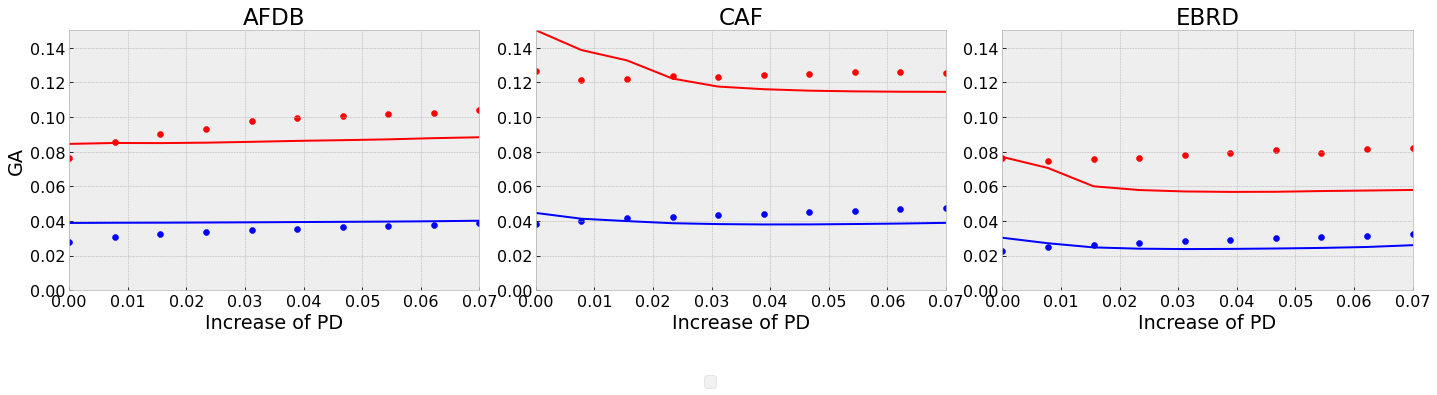

In [68]:
# Create a figure with 5 subplots
fig, axs = plt.subplots(1, len(portfolios_0999), figsize=(20, 5))


# Flatten the 2D array of axes so we can iterate over it
axs = axs.flatten()

# Set x and y limits (replace with the range you want)
x_limits = [min(pd_increase), max(pd_increase)]  # Example: based on pd_increase
y_limits = [0, 0.15]  # Replace with appropriate y-limits based on your data


# Initialize lists for the plot handles and labels for the global legend
handles = []
labels = []





# Plot for other portfolios
i = 0
for portfolio in portfolios_0999:
#     if i == 0:
#         # Plot for the base portfolio
#         line1, = axs[0].plot(pd_increase, GA_NN_01, label=r"$ELGD = 0.1$", color="blue")
#         line2, = axs[0].plot(pd_increase, GA_NN_045, label=r"$ELGD = 0.45$", color="red")
#         axs[0].set_title("Base Portfolio")
#         axs[i].scatter(pd_increase, GA_MC_01, color="blue")
#         axs[i].scatter(pd_increase, GA_MC_045, color="red")
#         # Collect the handles and labels for the legend
#         handles.extend([line1, line2])
#         labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$"])

#         # Apply the x and y limits for the first subplot
#         axs[0].set_xlim(x_limits)
#         axs[0].set_ylim(y_limits)
#         # Show x-axis labels only for the last row of subplots
#         i += 1

    axs[i].plot(pd_increase, GA_NN_PF_01[portfolio], color="blue")
    axs[i].plot(pd_increase, GA_NN_PF_045[portfolio], color="red")
    axs[i].scatter(pd_increase, GA_MC_PF_01[portfolio], color="blue")
    axs[i].scatter(pd_increase, GA_MC_PF_045[portfolio], color="red")
    axs[i].set_title(str(portfolio))

    # Apply the same x and y limits for each subplot
    axs[i].set_xlim(x_limits)
    axs[i].set_ylim(y_limits)

    # Show x-axis labels only for the last row of subplots
    axs[i].set_xlabel("Increase of PD")
    axs[i].set_ylabel("")
    
    i += 1

axs[0].set_xlabel("Increase of PD")
axs[0].set_ylabel("GA")

# Add a single legend to the figure, using the collected handles and labels
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('Plots/actuarial_sensitivity_PD_increase_01.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Only vary the EAD concentration

In [54]:
def determine_alpha(exposures,target_HHI,init_val = 1.25):
    def target(alpha):
        exposures_new = exposures**alpha/(np.sum(exposures**alpha))
        return np.abs(np.sum((exposures_new/np.sum(exposures_new))**2)-target_HHI)
    alpha_opt = minimize(target,init_val).x
    return alpha_opt

In [55]:
GA_NN_PF_01_HHI = {}
GA_NN_PF_045_HHI = {}
GA_MC_PF_01_HHI = {}
GA_MC_PF_045_HHI = {}
GA_HHI_PF = {}
for portfolio in portfolios_0999:
    GA_NN_PF_01_HHI[portfolio] = []
    GA_NN_PF_045_HHI[portfolio] = []
    GA_MC_PF_01_HHI[portfolio] = []
    GA_MC_PF_045_HHI[portfolio] = []
    for i in range(10):            
        # 10 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        
        GA_HHI_PF[portfolio] = np.sum((EAD/np.sum(EAD))**2)
        
        ELGD = np.array([0.1]*len(EAD))
        h = GA_HHI_PF[portfolio]*(i+9)/10  
        alpha_opt = determine_alpha(EAD[EAD>0],h)        
        EAD = np.reshape(np.append(EAD**alpha_opt/np.sum(EAD**alpha_opt),[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        PD = np.reshape(np.append(PD,[0]*(100-len(PD))),(1,100))
        omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
        Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)   
        GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                              ELGD[0,:][EAD[0,:]>0],
                              EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                                  q = 0.999, # quantile level
                                  xi = 0.25, # precision parameter,
                                  nu = 0.25,# recovery parameter
                                  rho = omega[0,:][EAD[0,:]>0],
                                  LGD_constant = False)
        Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
        GA_NN_PF_01_HHI[portfolio].append(model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0])
        MC = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]
        GA_MC_PF_01_HHI[portfolio].append(MC)       
        
        
        # 45 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        
        ELGD = np.array([0.45]*len(EAD))
        alpha_opt = determine_alpha(EAD[EAD>0],h)        
        EAD = np.reshape(np.append(EAD**alpha_opt/np.sum(EAD**alpha_opt),[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        PD = np.reshape(np.append(PD,[0]*(100-len(PD))),(1,100))
        omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
        Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)   
        GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                              ELGD[0,:][EAD[0,:]>0],
                              EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                                  q = 0.999, # quantile level
                                  xi = 0.25, # precision parameter,
                                  nu = 0.25,# recovery parameter
                                  rho = omega[0,:][EAD[0,:]>0],
                                  LGD_constant = False)
        Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
        GA_NN_PF_045_HHI[portfolio].append(model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0])  
        MC = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]
        GA_MC_PF_045_HHI[portfolio].append(MC)

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: Th

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: Th

MLE coincides with number of borrowers (independent of $\alpha$):

$$
\frac{1}{1/n \sum_{i=1}^N a_i'} = \frac{n}{ \frac{\sum_{i=1}^N a_i^{\alpha}}{\sum_{j=1}^N a_i^{\alpha}}} = n
$$

Synthetic Portfolio

In [56]:
GA_NN_01_HHI = []
GA_NN_045_HHI = []
GA_MC_01_HHI = []
GA_MC_045_HHI = []

for i in range(8):
    GA_HHI_base = np.sum((EAD_Vector/np.sum(EAD_Vector))**2)
    h = GA_HHI_base*(i+9)/10    
    alpha = determine_alpha(EAD_Vector,h)
    GA_approx_01 = GA_GL(PD_Vector[LGD_Vector>0],
                           LGD_Vector1[LGD_Vector>0],
                           (EAD_Vector[LGD_Vector>0]**alpha)/np.sum(EAD_Vector[LGD_Vector>0]**alpha), 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)
    inp_01 = tf.concat([LGD_Vector1,
                          (EAD_Vector**alpha)/np.sum(EAD_Vector**alpha),
                          PD_Vector,
                          rho_Vector,
                                np.reshape(GA_approx_01,(1,1))],axis =1) 
  
    GA_NN_01_HHI.append(model_actuarial_0999(scaler_actuarial.transform(inp_01)).numpy()[0][0])
    
    MC = MC_IS_actuarial(np.reshape(LGD_Vector1,(1,100)),
                                             np.reshape((EAD_Vector**alpha)/np.sum(EAD_Vector**alpha),(1,100)),
                                            np.reshape(PD_Vector,(1,100)),
                                            np.reshape(rho_Vector,(1,100)),
                                             q=0.999,n = n_mc)[0]
    GA_MC_01_HHI.append(MC)     
    
    GA_approx_045 = GA_GL(PD_Vector[LGD_Vector>0]+increase,
                           LGD_Vector2[LGD_Vector>0],
                           (EAD_Vector[LGD_Vector>0]**alpha)/np.sum(EAD_Vector[LGD_Vector>0]**alpha), 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)
    inp_045 = tf.concat([LGD_Vector2,
                          (EAD_Vector**alpha)/np.sum(EAD_Vector**alpha),
                          PD_Vector+increase,
                          rho_Vector,
                                np.reshape(GA_approx_045,(1,1))],axis =1) 
    GA_NN_045_HHI.append(model_actuarial_0999(scaler_actuarial.transform(inp_045)).numpy()[0][0])
    MC = MC_IS_actuarial(np.reshape(LGD_Vector2,(1,100)),
                                             np.reshape((EAD_Vector**alpha)/np.sum(EAD_Vector**alpha),(1,100)),
                                            np.reshape(PD_Vector,(1,100)),
                                            np.reshape(rho_Vector,(1,100)),
                                             q=0.999,n = n_mc)[0]
    GA_MC_045_HHI.append(MC)   

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: Th

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


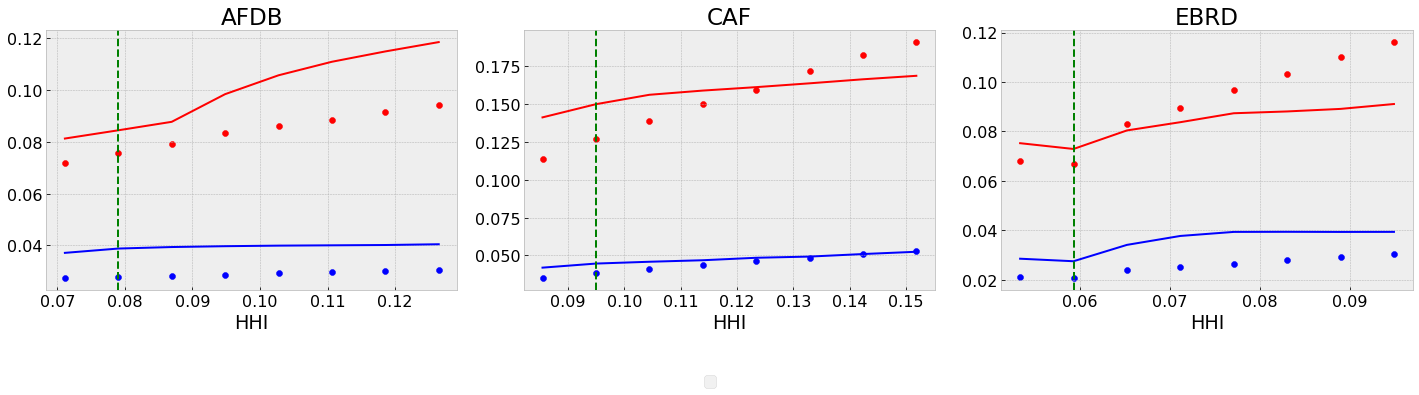

In [70]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, len(portfolios_0999), figsize=(20, 5))


# Flatten the 2D array of axes so we can iterate over it
axs = axs.flatten()

# # Set x and y limits (replace with the range you want)
# x_limits = [GA_HHI_base*(9)/10  , GA_HHI_base*(19)/10  ]  # Example: based on pd_increase
# y_limits = [0, 0.25]  # Replace with appropriate y-limits based on your data


# Initialize lists for the plot handles and labels for the global legend
handles = []
labels = []



# Plot for other portfolios
i = 0
for portfolio in portfolios_0999:
#     if i == 0:
#         # Plot for the base portfolio
#         line1, = axs[0].plot([GA_HHI_base*(i+9)/10 for i in range(8)]  , GA_NN_01_HHI, label=r"$ELGD = 0.1$", color="blue")
#         line2, = axs[0].plot([GA_HHI_base*(i+9)/10  for i in range(8)] , GA_NN_045_HHI, label=r"$ELGD = 0.45$", color="red")
#         line3 = axs[0].axvline(x= GA_HHI_base, color='g', linestyle='--', label='HHI')
#         axs[0].set_title("Base Portfolio")
#         axs[i].scatter([GA_HHI_base*(i+9)/10 for i in range(8)], GA_MC_01_HHI, color="blue")
#         axs[i].scatter([GA_HHI_base*(i+9)/10 for i in range(8)], GA_MC_045_HHI, color="red")
#         # Collect the handles and labels for the legend
#         handles.extend([line1, line2,line3])
#         labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$", "Current HHI"])
#         axs[0].set_xlabel("HHI")
#         axs[0].set_ylabel("GA")
        
#         i+= 1
    
    axs[i].plot([GA_HHI_PF[portfolio]*(i+9)/10 for i in range(8)], GA_NN_PF_01_HHI[portfolio][:8], color="blue")
    axs[i].plot([GA_HHI_PF[portfolio]*(i+9)/10 for i in range(8)], GA_NN_PF_045_HHI[portfolio][:8], color="red")
    axs[i].scatter([GA_HHI_PF[portfolio]*(i+9)/10 for i in range(8)], GA_MC_PF_01_HHI[portfolio][:8], color="blue")
    axs[i].scatter([GA_HHI_PF[portfolio]*(i+9)/10 for i in range(8)], GA_MC_PF_045_HHI[portfolio][:8], color="red")
    axs[i].axvline(x= GA_HHI_PF[portfolio], color='g', linestyle='--', label='x=5')
    axs[i].set_title(str(portfolio))

    # Apply the same x and y limits for each subplot
    #axs[i].set_xlim(GA_HHI_PF[portfolio]*9/10,GA_HHI_PF[portfolio]*19/10)
    #axs[i].set_ylim()

    # Show x-axis labels only for the last row of subplots
    axs[i].set_xlabel("HHI")
    axs[i].set_ylabel("")
    i += 1

# Add a single legend to the figure, using the collected handles and labels
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to prevent overlap
plt.tight_layout()
# Save the figure as a PDF
plt.savefig('Plots/actuarial_sensitivity_HHI_increase_01.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## Consider the GA Change in different scenarios:

Scenario 1: normal: PD as observed, EAD as observed, LGD = 0.1

Scenario 2: medium: PD increased by 2 % EAD slightly more concentrated, LGD = 0.1

Scenario 3: severe: PD increased by 4 % EAD more concentrated, LGD = 0.45

Scenario 4: medium: PD increased by 7 % EAD much more concentrated, LGD = 0.45

Reweight exposures according to

$$
E_i' = \frac{E_i^\alpha}{\sum_{i}E_i^\alpha}
$$

for exponents alpha such that HHI increases bby  25 %, 50 %, 100% for scenario 2, scenario 3, scenbario 4

In [26]:
def determine_alpha(exposures,target_HHI,init_val = 1):
    def target(alpha):
        exposures_new = exposures**alpha/(np.sum(exposures**alpha))
        return np.abs(np.sum((exposures_new/np.sum(exposures_new))**2)-target_HHI)
    alpha_opt = minimize(target,init_val).x
    return alpha_opt

First the computations for the synthetic portfolio

In [27]:
# Compute GA under Scenario 1
GA_scenario_1= {}
GA_scenario_1_MC = {}
GA_approx_01 = GA_GL(PD_Vector[LGD_Vector>0],
                           LGD_Vector1[LGD_Vector>0],
                           EAD_Vector[LGD_Vector>0], 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)

inp_01 = tf.concat([LGD_Vector1,
                      EAD_Vector,
                      PD_Vector,
                      rho_Vector,
                            np.reshape(GA_approx_01,(1,1))],axis =1) 
GA_scenario_1["Base"] = model_actuarial_0999(scaler_actuarial.transform(inp_01)).numpy()[0][0]
GA_scenario_1_MC["Base"] = MC_IS_actuarial(np.reshape(LGD_Vector1,(1,100)),
                                             np.reshape(EAD_Vector,(1,100)),
                                            np.reshape(PD_Vector,(1,100)),
                                            np.reshape(rho_Vector,(1,100)),
                                             q=0.999,n = n_mc)[0]

# Compute GA under Scenario 2
GA_scenario_2= {}
GA_scenario_2_MC = {}

h = np.sum((EAD_Vector/np.sum(EAD_Vector))**2)
alpha_scen_2 = determine_alpha(EAD_Vector[EAD_Vector>0],h*1.25)
GA_approx_02 = GA_GL(PD_Vector[LGD_Vector>0]+0.02,
                           LGD_Vector1[LGD_Vector>0],
                           (EAD_Vector[LGD_Vector>0]**alpha_scen_2)/np.sum(EAD_Vector[LGD_Vector>0]**alpha_scen_2), 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)


inp_02 = tf.concat([LGD_Vector1,
                      EAD_Vector**alpha_scen_2/np.sum(EAD_Vector**alpha_scen_2),
                      np.reshape(np.concatenate([PD_Vector[PD_Vector>0]+0.02,np.repeat(0,50)]),(1,100)),
                      rho_Vector,
                            np.reshape(GA_approx_02,(1,1))],axis =1) 
GA_scenario_2["Base"] = model_actuarial_0999(scaler_actuarial.transform(inp_02)).numpy()[0][0]
PD_mod = PD_Vector
PD_mod[PD_mod>0] += 0.02
GA_scenario_2_MC["Base"] = MC_IS_actuarial(np.reshape(LGD_Vector1,(1,100)),
                                             np.reshape(EAD_Vector**alpha_scen_2/np.sum(EAD_Vector**alpha_scen_2),(1,100)),
                                            np.reshape(PD_mod,(1,100)),
                                            np.reshape(rho_Vector,(1,100)),
                                             q=0.999,n = n_mc)[0]
# # Compute GA under Scenario 3
GA_scenario_3= {}
GA_scenario_3_MC = {}

h = np.sum((EAD_Vector/np.sum(EAD_Vector))**2)
alpha_scen_3 = determine_alpha(EAD_Vector[EAD_Vector>0],h*1.50)

GA_approx_03 = GA_GL(PD_Vector[LGD_Vector>0]+0.04,
                           LGD_Vector2[LGD_Vector>0],
                           (EAD_Vector[LGD_Vector>0]**alpha_scen_3)/np.sum(EAD_Vector[LGD_Vector>0]**alpha_scen_3), 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)

inp_03 = tf.concat([LGD_Vector2,
                      EAD_Vector**alpha_scen_3/np.sum(EAD_Vector**alpha_scen_3),
                      np.reshape(np.concatenate([PD_Vector[PD_Vector>0]+0.04,np.repeat(0,50)]),(1,100)),
                      rho_Vector,
                            np.reshape(GA_approx_03,(1,1))],axis =1) 
GA_scenario_3["Base"] = model_actuarial_0999(scaler_actuarial.transform(inp_03)).numpy()[0][0]
PD_mod = PD_Vector
PD_mod[PD_mod>0] += 0.04
GA_scenario_3_MC["Base"] = MC_IS_actuarial(np.reshape(LGD_Vector2,(1,100)),
                                             np.reshape(EAD_Vector**alpha_scen_3/np.sum(EAD_Vector**alpha_scen_3),(1,100)),
                                            np.reshape(PD_mod,(1,100)),
                                            np.reshape(rho_Vector,(1,100)),
                                             q=0.999,n = n_mc)[0]
# # Compute GA under Scenario 4
GA_scenario_4= {}
GA_scenario_4_MC = {}

h = np.sum((EAD_Vector/np.sum(EAD_Vector))**2)
alpha_scen_4 = determine_alpha(EAD_Vector[EAD_Vector>0],h*2)

GA_approx_04 = GA_GL(PD_Vector[LGD_Vector>0]+0.07,
                           LGD_Vector2[LGD_Vector>0],
                           (EAD_Vector[LGD_Vector>0]**alpha_scen_4)/np.sum(EAD_Vector[LGD_Vector>0]**alpha_scen_4), 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)

inp_04 = tf.concat([LGD_Vector2,
                      EAD_Vector**alpha_scen_4/np.sum(EAD_Vector**alpha_scen_4),
                      np.reshape(np.concatenate([PD_Vector[PD_Vector>0]+0.07,np.repeat(0,50)]),(1,100)),
                      rho_Vector,
                            np.reshape(GA_approx_04,(1,1))],axis =1) 
GA_scenario_4["Base"] = model_actuarial_0999(scaler_actuarial.transform(inp_04)).numpy()[0][0]
PD_mod = PD_Vector
PD_mod[PD_mod>0] += 0.7
GA_scenario_4_MC["Base"] = MC_IS_actuarial(np.reshape(LGD_Vector2,(1,100)),
                                             np.reshape(EAD_Vector**alpha_scen_4/np.sum(EAD_Vector**alpha_scen_4),(1,100)),
                                            np.reshape(PD_mod,(1,100)),
                                            np.reshape(rho_Vector,(1,100)),
                                             q=0.999,n = n_mc)[0]

print("The chosen alphas are :{}, {}, {}".format(alpha_scen_2,alpha_scen_3,alpha_scen_4))

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: Th

The chosen alphas are :[1.18247895], [1.34307818], [1.63353782]


Now the computations for the real portfolios

In [29]:
def to_solve(om,PD,EAD,ELGD,q=0.999):
    b = (0.11852-0.05478*np.log(PD))**2
    R_corr = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
    K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
    alpha_X =  gamma.ppf(q=0.999,a =0.25, scale = 1/0.25)
    return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))

In [31]:
for portfolio in portfolios_0999_all:
    

    
    # Compute GA under Scenario 1
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]
    ELGD = np.array([0.1]*len(EAD))
    EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
    PD = np.reshape(np.append(PD,[0]*(100-len(PD))),(1,100))
    omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
    Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)   
    GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                          ELGD[0,:][EAD[0,:]>0],
                          EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                              q = 0.999, # quantile level
                              xi = 0.25, # precision parameter,
                              nu = 0.25,# recovery parameter
                              rho = omega[0,:][EAD[0,:]>0],
                              LGD_constant = False)
    Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
    
    
    GA_scenario_1[portfolio] = model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]

    GA_scenario_1_MC[portfolio] = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]

      
    # Compute GA under Scenario 2
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]  
    ELGD = np.array([0.1]*len(EAD))
    omega = fsolve(lambda x: to_solve(x,np.minimum(PD+0.02,0.5147),EAD,ELGD),[0.25]*len(EAD))
    omega = np.minimum(omega,1)
    omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
    h = np.sum((EAD/np.sum(EAD))**2)
    alpha_scen_2 = determine_alpha(EAD[EAD>0],h*1.25)
    EAD = np.reshape(np.append(EAD**alpha_scen_2/np.sum(EAD**alpha_scen_2),[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))

    PD = np.reshape(np.append(np.minimum(PD+0.02,0.5147),[0]*(100-len(PD))),(1,100))
    Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)    
    GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                          ELGD[0,:][EAD[0,:]>0],   
                         EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                              q = 0.999, # quantile level
                              xi = 0.25, # precision parameter,
                              nu = 0.25,# recovery parameter
                              rho = omega[0,:][EAD[0,:]>0],
                              LGD_constant = False)
    Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
    model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]
    
    GA_scenario_2[portfolio] = model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]
    GA_scenario_2_MC[portfolio] = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]
    # # Compute GA under Scenario 3
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]  
    ELGD = np.array([0.45]*len(EAD))
    omega = fsolve(lambda x: to_solve(x,np.minimum(PD+0.04,0.5147),EAD,ELGD),[0.25]*len(EAD))
    omega = np.minimum(omega,1)
    omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
    h = np.sum((EAD/np.sum(EAD))**2)
    alpha_scen_3 = determine_alpha(EAD[EAD>0],h*1.5)
    EAD = np.reshape(np.append(EAD**alpha_scen_3/np.sum(EAD**alpha_scen_3),[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
    PD = np.reshape(np.append(np.minimum(PD+0.04,0.5147),[0]*(100-len(PD))),(1,100))
    Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)      
    GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                          ELGD[0,:][EAD[0,:]>0],
                          EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                              q = 0.999, # quantile level
                              xi = 0.25, # precision parameter,
                              nu = 0.25,# recovery parameter
                              rho = omega[0,:][EAD[0,:]>0],
                              LGD_constant = False)
    Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
    model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]
    
    GA_scenario_3[portfolio] = model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]
    GA_scenario_3_MC[portfolio] = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]
    # # Compute GA under Scenario 4
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]  
    ELGD = np.array([0.45]*len(EAD))
    h = np.sum((EAD/np.sum(EAD))**2)
    omega = fsolve(lambda x: to_solve(x,np.minimum(PD+0.07,0.5147),EAD,ELGD),[0.25]*len(EAD))
    omega = np.minimum(omega,1)
    omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
    alpha_scen_4 = determine_alpha(EAD[EAD>0],h*2)
    EAD = np.reshape(np.append(EAD**alpha_scen_4/np.sum(EAD**alpha_scen_4),[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
    PD = np.reshape(np.append(np.minimum(PD+0.07,0.5147),[0]*(100-len(PD))),(1,100))
    Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)      
    GA_approx = GA_GL(PD[0,:][EAD[0,:]>0],
                          ELGD[0,:][EAD[0,:]>0],
                          EAD[0,:][EAD[0,:]>0], 1, # Vector of Maturities
                              q = 0.999, # quantile level
                              xi = 0.25, # precision parameter,
                              nu = 0.25,# recovery parameter
                              rho = omega[0,:][EAD[0,:]>0],
                              LGD_constant = False)
    Input_2 = np.concatenate([Input,np.reshape(GA_approx,(1,1))],axis = 1)
    model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]
    
    GA_scenario_4[portfolio] = model_actuarial_0999.predict(scaler_actuarial.transform(Input_2))[0][0]
    GA_scenario_4_MC[portfolio] = MC_IS_actuarial(np.reshape(ELGD[0,:],(1,100)),
                                                 np.reshape(EAD[0,:],(1,100)),
                                                np.reshape(PD[0,:],(1,100)),
                                                np.reshape(omega[0,:],(1,100)),
                                                 q=0.999,n = n_mc)[0]

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [32]:
df1 = pd.DataFrame([GA_scenario_1,GA_scenario_2,GA_scenario_3,GA_scenario_4])
df1.index = ["Scenario 1", "Scenario 2","Scenario 3", "Scenario 4"]
df1.drop(columns=["Base"], inplace=True)
df_percentage1 = df1.applymap(lambda x: f"{x * 100:.2f}")
df_percentage1

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Scenario 1,4.46,3.67,3.88,4.15,3.77,6.58,5.62,2.33,5.61,5.14,3.03
Scenario 2,4.57,3.78,4.03,4.15,3.91,6.73,16.72,2.38,6.91,4.71,2.97
Scenario 3,15.70,8.10,10.63,10.50,13.42,18.69,24.66,5.07,17.13,16.45,9.10
Scenario 4,16.73,14.55,13.30,14.55,15.36,21.47,28.83,5.59,19.63,15.73,10.17


Monte Carlo Results

In [33]:
df2 = pd.DataFrame([GA_scenario_1_MC,GA_scenario_2_MC,GA_scenario_3_MC,GA_scenario_4_MC])
df2.index = ["Scenario 1", "Scenario 2","Scenario 3", "Scenario 4"]
df2.drop(columns=["Base"], inplace=True)
df_percentage2 = df2.applymap(lambda x: f"{x * 100:.2f}")
df_percentage2

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Scenario 1,3.81,2.16,2.78,2.81,4.00,4.99,5.30,1.41,5.22,4.78,2.24
Scenario 2,4.82,3.48,3.58,3.79,4.71,6.32,7.08,2.22,5.97,5.08,3.02
Scenario 3,17.93,14.48,13.87,14.79,18.28,27.61,43.58,7.97,19.97,20.06,11.36
Scenario 4,23.13,19.47,18.63,19.40,23.06,35.07,54.89,10.75,24.95,16.73,15.03


In [34]:
df3 = (df1-df2)/df2
df3 = df3.applymap(lambda x: f"{np.abs(x) * 100:.2f}")
df3['Average Error (%)'] = df3.astype(float).mean(axis=1)
df3['Average Error (%)'] = df3['Average Error (%)'].round(2)
df3

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD,Average Error (%)
Scenario 1,17.15,70.48,39.88,47.86,5.87,31.76,6.21,65.43,7.58,7.41,34.89,30.41
Scenario 2,5.26,8.78,12.66,9.61,17.04,6.58,135.96,6.97,15.64,7.23,1.56,20.66
Scenario 3,12.44,44.10,23.35,29.01,26.60,32.31,43.41,36.37,14.22,17.98,19.90,27.24
Scenario 4,27.66,25.31,28.62,25.02,33.38,38.77,47.47,47.98,21.34,5.99,32.30,30.35
